# 1. Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Load Train & Test Data

In [57]:
train_df = pd.read_csv('KDDTrain+.txt', )
test_df = pd.read_csv('KDDTest+.txt', )

# 3. Data Pre-Processing

## 3.1. Adjust column

In [58]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count','srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_df.columns = columns
test_df.columns = columns

In [59]:
train_df["attack"].value_counts()

attack
normal             67342
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [60]:
test_df["attack"].value_counts()

attack
normal             9711
neptune            4656
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
loadmodule            2
worm                  2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count, dtype: int64

## 3.2. Classify Attack Column as Normal & attack

In [61]:
attack_n = []
for i in train_df.attack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
train_df['attack'] = attack_n 

In [62]:
attack_n = []
for i in test_df.attack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
test_df['attack'] = attack_n 

## 3.3. Preprocess categorical features

In [63]:
protocol_type_le = preprocessing.LabelEncoder()
service_le = preprocessing.LabelEncoder()
flag_le = preprocessing.LabelEncoder()

## 3.4. Convert Categorical Data into Numerical Data

In [64]:
train_df['protocol_type'] = protocol_type_le.fit_transform(train_df['protocol_type'])
train_df['service'] = service_le.fit_transform(train_df['service'])
train_df['flag'] = flag_le.fit_transform(train_df['flag'])

In [65]:
test_df['protocol_type'] = protocol_type_le.fit_transform(test_df['protocol_type'])
test_df['service'] = service_le.fit_transform(test_df['service'])
test_df['flag'] = flag_le.fit_transform(test_df['flag'])

## 3.5. Define features and labels

In [66]:
X_train = train_df.drop(columns=['attack'])
Y_train = train_df['attack']

In [67]:
X_test = test_df.drop(columns=['attack'])
Y_test = test_df['attack']

### 3.5.1. Check how many data points are labeled as "attack" and "normal"

In [68]:
attack_counts = train_df['attack'].value_counts()
print("Attack counts:\n", attack_counts)

Attack counts:
 attack
normal    67342
attack    58630
Name: count, dtype: int64


In [69]:
attack_counts = test_df['attack'].value_counts()
print("Attack counts:\n", attack_counts)

Attack counts:
 attack
attack    12832
normal     9711
Name: count, dtype: int64


# 4. Model Training using GBM

## 4.1. Standardizing the Features

In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## 4.2. Creating the Gradient Boosting Model

In [71]:
model = GradientBoostingClassifier(random_state=40)

## 4.3. Model Training

In [72]:
model.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=40)

## 4.4. Save the Model and Scaler

In [73]:
joblib.dump(model, 'gbm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# 5. Evaluating Model

## 5.1. Load the Scaler and Standardize Features

In [74]:
scaler = joblib.load('scaler.pkl')
X_test = scaler.transform(X_test)

## 5.2. Load the Gradient Boosting Model

In [75]:
model = joblib.load('gbm_model.pkl')

## 5.3. Make Predictions

In [76]:
Y_pred = model.predict(X_test)

## 5.4. Calculate Accuracy

In [77]:
accuracy = accuracy_score(Y_test, Y_pred)
print('Testing accuracy:', accuracy)

Testing accuracy: 0.8529476999512043


In [78]:
report = classification_report(Y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

      attack       0.97      0.77      0.86     12832
      normal       0.76      0.97      0.85      9711

    accuracy                           0.85     22543
   macro avg       0.86      0.87      0.85     22543
weighted avg       0.88      0.85      0.85     22543



## 5.5. Plot Confusion Matrix

In [79]:
def plot_cm(y_true, y_pred, title):
    figsize=(10,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "mako", annot=annot, fmt='', ax=ax)

/tmp/ipykernel_3830/2836768641.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


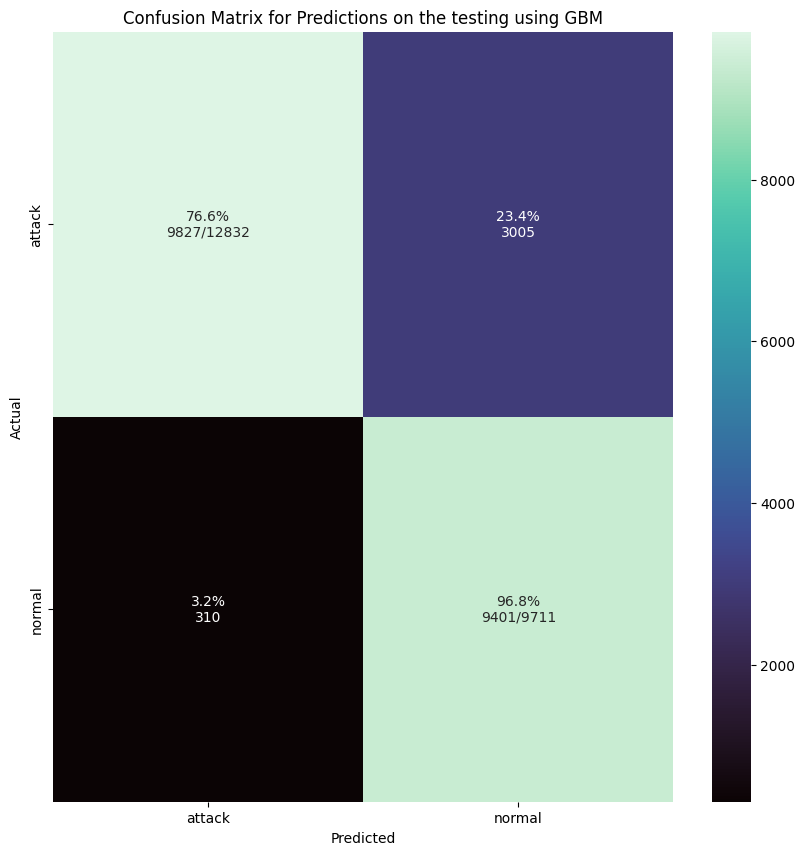

In [80]:
plot_cm(Y_test, Y_pred, 'Confusion Matrix for Predictions on the testing using GBM')